# Laboratorio 2
## Microestructuras y Sistemas de Trading
###  Pablo Mendoza

El presente laboratorio tiene como objetivo analizar el comportamiento de un ETF de acuerdo a la conformación de este y al movimiento de los precios que se presentaron entre el 31 de marzo del 2017 hasta el 29 de marzo del 2018 con el fin de identificar que tan conveniente es para un inversionista rebalancear diariamente durante un año comprando $n$ acciones cuando el rendimiento diario sea de -1%. Se contrastará el capital inicial con el capital final deshaciendo todas las pocisiones del portafolo el 1 de Marzo de 2018. Se realizan diferentes medidas de desempeño que permitan comparar los portafolios resultantes.

## Librerías y Funciones 

In [125]:
# Librerias
import quandl
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
fechas = list(['2017-03-31','2018-03-29'])

In [189]:
data_csv = pd.read_csv('/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/Trading/Data/IJH_holdings-1.csv', skiprows = [0,1,2,3,4,5,6,7,8,9], index_col = ['Ticker'])
tick = list(data_csv.index)
weights = data_csv['Weight (%)']/100
#del data_csv
def Download_QuandL(fechas:'Dates_list ', tick:'Tickers of Stock'):
    dates = { 'gte': fechas[0], 'lte': fechas[1] }
    column = { 'columns': ['date', 'Open', 'Close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tick, date = dates, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    data = data.iloc[::-1]
    data = data.reset_index()
    data = data.drop(['None'],1)
    return data
def All_Data(fechas:'Dates_list ', tick:'Ticker'):
    d = {} # Crea un Diccionario Vacío
    for i in range(len(tick)): # ciclo que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
        nom = str(tick[i])
        d["_{0}".format(nom)] = Download_QuandL(fechas, tick[i])
    return d
def Rebalanceo(df, Com, Cap_I, R_R, n_a, we, op, t, full):
    """
    Esta funcion hace los rebalanceos de cada activo de forma diaria por una año
    :param df: DataFrame del Activo
    :param Com: Comisión
    :param Cap_I: Capital Inicial
    :param R_R: Rendimiento de Rebalanceo
    :param n_a: Acciones que se compran al rebalancear
    :param we: Weight of each stock on the porfolio
    :param op: Dataframe to save operation
    :param t: ticker
    :return: 
    """
    a = (df['close']/df['open'])-1
    P_se = list(df['open']*.99)
    add_s = list()
    Opp = list()
    comi = list()
    In_shares = np.floor((we*Cap_I)/df['close'][0])
    for i in range(len(df)):
        if a.iloc[i] < R_R:
            add_s.append(n_a)
            Opp.append('Compra')
            comi.append(Com*df['close'].iloc[i]*n_a)
        else:
            add_s.append(0)
            Opp.append('-')
            comi.append(0)
    rt = list(np.ones(len(df)))
    rt = pd.DataFrame([t if x % 2 else Pass for x in rt], columns = ['Ticker'])      
    df = df.join(pd.DataFrame(add_s, columns = ['# Added Shares']))
    df = df.join(pd.DataFrame(Opp, columns = ['Operacion']))
    df = df.join(pd.DataFrame(comi, columns = ['Comisión']))
    df = df.join(pd.DataFrame(P_se, columns = ['Precio de Señal']))
    Tot_Acciones = pd.DataFrame(list(df['# Added Shares'].cumsum()), columns = ['Total Shares'])+In_shares
    df = df.join(Tot_Acciones)
    Val_to_port = pd.DataFrame(list(df['close']*df['Total Shares']), columns = ['Value to ETF'])
    df = df.join(Val_to_port)
    df = df.join(rt)
    frames = [op, df[df.Operacion == 'Compra']]
    op = pd.concat(frames)
    temp_data = [full, df]
    full = pd.concat(temp_data)
    return df, op, full
def Clean_Dicc(dic:'Diccionario a limpiar',sizes:'Tamaño deseado del DF'):
    y = list(dic.keys())
    for h in y:
        if len(dic[h])!=248:
            del dic[h]
    return dic

In [4]:
Data = All_Data(fechas, tick)

In [5]:
d_full = Clean_Dicc(Data,248)

## Esenario hipotético suponiendo comisión de .0003 y comprando 10 activos por rebalanceo

In [234]:
tick = list(d_full.keys())
d2 = {}
op = pd.DataFrame(columns=['date', 'open', 'close', '# Added Shares', 'Operacion', 'Comisión', 'Precio de Señal', 'Total Shares', 'Value to ETF', 'Ticker'''])
full = pd.DataFrame(columns=['date', 'open', 'close', '# Added Shares', 'Operacion', 'Comisión', 'Precio de Señal', 'Total Shares', 'Value to ETF', 'Ticker'''])
for j in range(len(tick)):
    tabla , op, full = Rebalanceo(d_full[tick[j]],.0003,10000000,-0.01,10,weights[j], op, tick[j], full)
    d2["Data{0}".format(j)] = tabla
op_2 = op.groupby('date')
full_2 = full.groupby('date')
#for key, item in op_2:
    #print(op_2.get_group(key), "\n\n")
Key_op_2 = list()
for key, item in op_2:
    Key_op_2.append(key)
Key_full_2 = list()
for key, item in full_2:
    Key_full_2.append(key)
# Data: tiene la información de todas las transacciones para cada activo en cada día
# op: tiene la información de todas las transacciones de compra para cada activo
# op_2: tiene la información de todas las transacciones de compra agrupada por día
l_comi = list()
diff_capital = list()
NAV = list()
Serie_ = list()
for w in range(len(op_2)):
    l_comi.append(float(pd.DataFrame(op_2.get_group(Key_op_2[w])['Comisión']).sum()))
    diff_capital.append(float(pd.DataFrame(pd.DataFrame(op_2.get_group(Key_op_2[w])['Precio de Señal'])['Precio de Señal']*pd.DataFrame(op_2.get_group(Key_op_2[w])['# Added Shares'])['# Added Shares']).sum()))
    NAV.append(float(full_2.get_group(Key_full_2[w])['Value to ETF'].sum())/float(full_2.get_group(Key_full_2[w])['Total Shares'].sum()))
    Serie_.append(float(full_2.get_group(Key_full_2[w])['Value to ETF'].sum()))

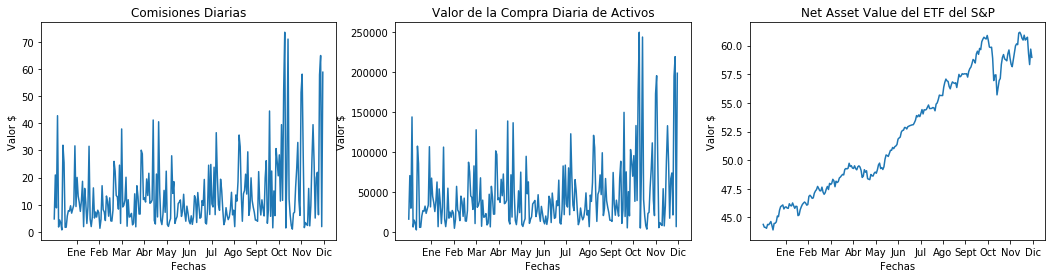

In [235]:
plt.figure(figsize = (18,4))
plt.subplot(131)
plt.plot(l_comi)
plt.title('Comisiones Diarias')
plt.xticks(np.arange(20.66,248,248/12), ('Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic'))
plt.xlabel('Fechas')
plt.ylabel('Valor $')
plt.subplot(132)
plt.plot(diff_capital)
plt.title('Valor de la Compra Diaria de Activos')
plt.xlabel('Fechas')
plt.xticks(np.arange(20.66,248,248/12), ('Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic'))
plt.ylabel('Valor $')
plt.subplot(133)
plt.plot(NAV)
plt.title('Net Asset Value del ETF del S&P')
plt.xlabel('Fechas')
plt.xticks(np.arange(20.66,248,248/12), ('Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic'))
plt.ylabel('Valor $')
plt.show()

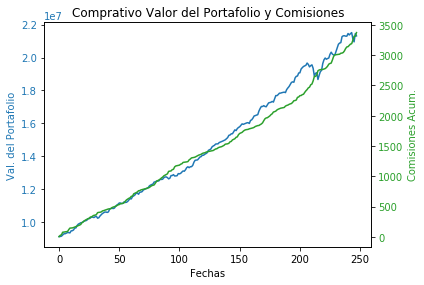

In [245]:
# Create some mock data
t = np.arange(0,248)
data1 = Serie_
data2 = pd.DataFrame(l_comi).cumsum()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Fechas')
ax1.set_ylabel('Val. del Portafolio', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Comisiones Acum.', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comprativo Valor del Portafolio y Comisiones')
plt.show()

## Esenario hipotético suponiendo comisión de .0003 y comprando 0 activos por rebalanceo

In [238]:
tick = list(d_full.keys())
d2 = {}
op = pd.DataFrame(columns=['date', 'open', 'close', '# Added Shares', 'Operacion', 'Comisión', 'Precio de Señal', 'Total Shares', 'Value to ETF', 'Ticker'''])
full = pd.DataFrame(columns=['date', 'open', 'close', '# Added Shares', 'Operacion', 'Comisión', 'Precio de Señal', 'Total Shares', 'Value to ETF', 'Ticker'''])
for j in range(len(tick)):
    tabla , op, full = Rebalanceo(d_full[tick[j]],.0003,10000000,-0.01,0,weights[j], op, tick[j], full)
    d2["Data{0}".format(j)] = tabla
op_2 = op.groupby('date')
full_2 = full.groupby('date')
#for key, item in op_2:
    #print(op_2.get_group(key), "\n\n")
Key_op_2 = list()
for key, item in op_2:
    Key_op_2.append(key)
Key_full_2 = list()
for key, item in full_2:
    Key_full_2.append(key)
# Data: tiene la información de todas las transacciones para cada activo en cada día
# op: tiene la información de todas las transacciones de compra para cada activo
# op_2: tiene la información de todas las transacciones de compra agrupada por día
l_comi_2 = list()
diff_capital_2 = list()
NAV_2 = list()
Serie_2 = list()
for w in range(len(op_2)):
    l_comi_2.append(float(pd.DataFrame(op_2.get_group(Key_op_2[w])['Comisión']).sum()))
    diff_capital_2.append(float(pd.DataFrame(pd.DataFrame(op_2.get_group(Key_op_2[w])['Precio de Señal'])['Precio de Señal']*pd.DataFrame(op_2.get_group(Key_op_2[w])['# Added Shares'])['# Added Shares']).sum()))
    NAV_2.append(float(full_2.get_group(Key_full_2[w])['Value to ETF'].sum())/float(full_2.get_group(Key_full_2[w])['Total Shares'].sum()))
    Serie_2.append(float(full_2.get_group(Key_full_2[w])['Value to ETF'].sum()))

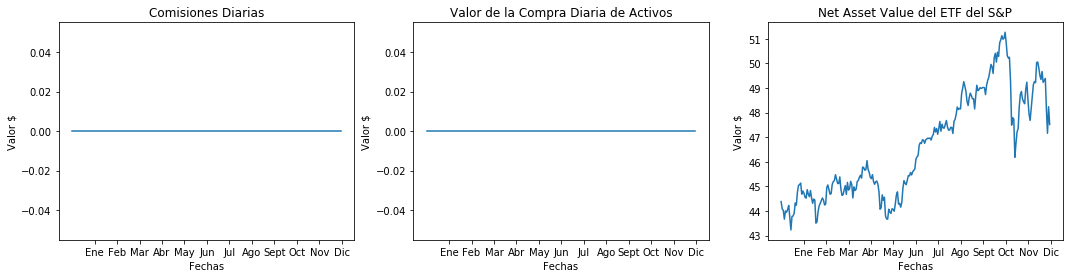

In [239]:
plt.figure(figsize = (18,4))
plt.subplot(131)
plt.plot(l_comi_2)
plt.title('Comisiones Diarias')
plt.xticks(np.arange(20.66,248,248/12), ('Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic'))
plt.xlabel('Fechas')
plt.ylabel('Valor $')
plt.subplot(132)
plt.plot(diff_capital_2)
plt.title('Valor de la Compra Diaria de Activos')
plt.xlabel('Fechas')
plt.xticks(np.arange(20.66,248,248/12), ('Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic'))
plt.ylabel('Valor $')
plt.subplot(133)
plt.plot(NAV_2)
plt.title('Net Asset Value del ETF del S&P')
plt.xlabel('Fechas')
plt.xticks(np.arange(20.66,248,248/12), ('Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic'))
plt.ylabel('Valor $')
plt.show()

Text(0.5,1,'Comprativo Valor del Portafolio y Comisiones')

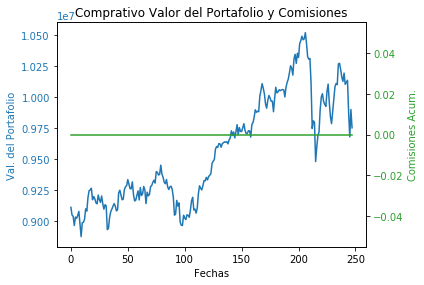

In [247]:
t = np.arange(0,248)
data1_2 = Serie_2
data2_2 = pd.DataFrame(l_comi_2).cumsum()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Fechas')
ax1.set_ylabel('Val. del Portafolio', color=color)
ax1.plot(t, data1_2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Comisiones Acum.', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comprativo Valor del Portafolio y Comisiones')